<a href="https://colab.research.google.com/github/dnzambuli/Deep-learning-4-CV/blob/master/Lab_work_week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instruction

1. Laboratory Assignment: Design and implement a simple CNN for image classification (YALM dataset: download:  using TensorFlow or PyTorch. (20M)

2. Evaluation Report: Evaluate the performance of the CNN using accuracy and loss metrics on a validation dataset. (10M)

[download link](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/datasets/african-wildlife.yaml)

## About the data




In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
data_url = "https://github.com/ultralytics/assets/releases/download/v0.0.0/african-wildlife.zip"

In [4]:
# download the zip data form the data_url

import requests
import zipfile
import io
import pandas as pd
import os

# Function to download and extract the zip file
def download_and_extract_zip(url, extract_path):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes

        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            zip_ref.extractall(extract_path)

        print(f"Successfully downloaded and extracted to {extract_path}")
        return True

    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")
        return False
    except zipfile.BadZipFile as e:
        print(f"Error extracting zip file: {e}")
        return False
    except Exception as e:
      print(f"An unexpected error occurred: {e}")
      return False

# Specify the path to extract data
extract_path = "/content/african_wildlife"
download_and_extract_zip(data_url, extract_path)

Successfully downloaded and extracted to /content/african_wildlife


True

In [5]:
# list all the files in this folder "/content/drive/african_wildlife"

import os

# Specify the directory path
directory_path = "/content/african_wildlife"

# Check if the directory exists
if os.path.exists(directory_path):
    # List all files and directories in the specified path
    files = os.listdir(directory_path)
    print(f"Files and directories in '{directory_path}':")
    for file in files:
        print(file)
else:
    print(f"Error: Directory '{directory_path}' not found.")

Files and directories in '/content/african_wildlife':
test
valid
train


# Read the training data

In [6]:
train_files = os.listdir("/content/african_wildlife/train")
train_files


['labels', 'images']

# Crop the images

In [7]:
from IPython.display import Markdown, display

markdown_text = '''
Training data appears like

| Image | Label | Coordinate |
|:---|:---:|:---|
| <img src="/content/african_wildlife/train/images/1 (100).jpg" alt="buffalo" width="200"> | 0 | 0.809746 0.574501 0.240320 0.835637 |
| <img src="/content/african_wildlife/train/images/1 (100).jpg" alt="buffalo" width="200"> | 0 | 0.809746 0.574501 0.240320 0.835637 |
| <img src="/content/african_wildlife/train/images/1 (100).jpg" alt="buffalo" width="200"> | 0 | 0.809746 0.574501 0.240320 0.835637 |
| <img src="/content/african_wildlife/train/images/2 (10).jpg" alt="Elephant" width="200"> | 1 | 0.508594 0.611458 0.189062 0.493750 |
| <img src="/content/african_wildlife/train/images/3 (1).jpg" alt="Rhino" width="200"> | 2 | 0.477941 0.535948 0.377451 0.880174 |
| <img src="/content/african_wildlife/train/images/3 (1).jpg" alt="Rhino" width="200"> | 2 | 0.477941 0.535948 0.377451 0.880174 |
| <img src="/content/african_wildlife/train/images/4 (101).jpg" alt="Zebra" width="200"> | 3 | 0.291406 0.453125 0.145313 0.360417 |
| <img src="/content/african_wildlife/train/images/4 (101).jpg" alt="Zebra" width="200"> | 3 | 0.545312 0.422917 0.209375 0.333333 |
| <img src="/content/african_wildlife/train/images/4 (101).jpg" alt="Zebra" width="200"> | 3 | 0.545312 0.422917 0.209375 0.333333 |
'''

display(Markdown(markdown_text))


Training data appears like

| Image | Label | Coordinate |
|:---|:---:|:---|
| <img src="/content/african_wildlife/train/images/1 (100).jpg" alt="buffalo" width="200"> | 0 | 0.809746 0.574501 0.240320 0.835637 |
| <img src="/content/african_wildlife/train/images/1 (100).jpg" alt="buffalo" width="200"> | 0 | 0.809746 0.574501 0.240320 0.835637 |
| <img src="/content/african_wildlife/train/images/1 (100).jpg" alt="buffalo" width="200"> | 0 | 0.809746 0.574501 0.240320 0.835637 |
| <img src="/content/african_wildlife/train/images/2 (10).jpg" alt="Elephant" width="200"> | 1 | 0.508594 0.611458 0.189062 0.493750 |
| <img src="/content/african_wildlife/train/images/3 (1).jpg" alt="Rhino" width="200"> | 2 | 0.477941 0.535948 0.377451 0.880174 |
| <img src="/content/african_wildlife/train/images/3 (1).jpg" alt="Rhino" width="200"> | 2 | 0.477941 0.535948 0.377451 0.880174 |
| <img src="/content/african_wildlife/train/images/4 (101).jpg" alt="Zebra" width="200"> | 3 | 0.291406 0.453125 0.145313 0.360417 |
| <img src="/content/african_wildlife/train/images/4 (101).jpg" alt="Zebra" width="200"> | 3 | 0.545312 0.422917 0.209375 0.333333 |
| <img src="/content/african_wildlife/train/images/4 (101).jpg" alt="Zebra" width="200"> | 3 | 0.545312 0.422917 0.209375 0.333333 |


## Code to do the cropping

In [8]:
def read_label_file(label_path):
    """
    Reads a YOLO-style label file and extracts bounding box coordinates.

    :param label_path: Path to the label file.
    :return: List of bounding boxes in normalized format [(x_center, y_center, width, height)].
    """
    bboxes = []
    with open(label_path, "r") as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 5:  # Format: class x_center y_center width height
                class_id, x_center, y_center, width, height = map(float, parts)
                bboxes.append((int(class_id), x_center, y_center, width, height))
    return bboxes

In [9]:
import cv2
import numpy as np

def crop_regions(image_path, label_path):
    """
    Crop regions from an image based on label data.

    :param image_path: Path to the image file.
    :param label_data: List of bounding boxes in normalized format [(x_center, y_center, width, height)].
    :return: List of cropped images as numpy arrays.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or unable to load.")

    height, width, _ = image.shape
    label_data = read_label_file(label_path)
    cropped_images = []

    for bbox in label_data:
        class_id, x_center, y_center, bbox_width, bbox_height = bbox

        # Convert normalized coordinates to absolute pixel values
        x1 = int((x_center - bbox_width / 2) * width)
        y1 = int((y_center - bbox_height / 2) * height)
        x2 = int((x_center + bbox_width / 2) * width)
        y2 = int((y_center + bbox_height / 2) * height)

        # Ensure coordinates are within image boundaries
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(width, x2), min(height, y2)

        # Crop the image and append
        cropped = image[y1:y2, x1:x2]
        cropped_images.append((cropped, class_id))

    return cropped_images


### attempt a crop

In [10]:
samp_buffalo = "/content/african_wildlife/train/images/1 (100).jpg"
samp_buffalo_label = "/content/african_wildlife/train/labels/1 (100).txt"
samp_crop = crop_regions(samp_buffalo, samp_buffalo_label)

### Display the crop

In [11]:
Animal_Labels = {
    0:"Buffalo",
    1:"Elephant",
    2:"Rhino",
    3:"Zebra"
}

Animal_Labels[1]

'Elephant'

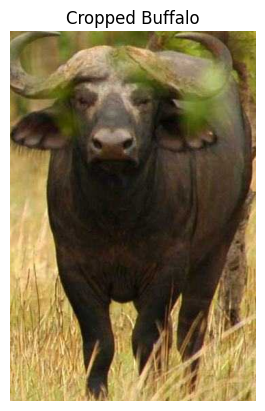

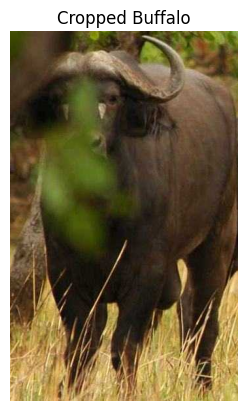

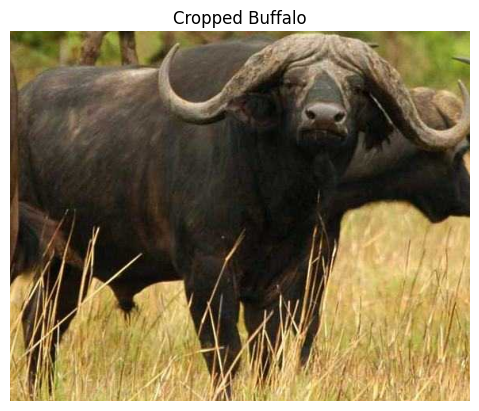

In [12]:
import matplotlib.pyplot as plt

for i, crop in enumerate(samp_crop):
    plt.imshow(cv2.cvtColor(crop[0], cv2.COLOR_BGR2RGB))
    plt.title(f"Cropped {Animal_Labels[crop[1]]}")
    plt.axis("off")
    plt.show()

# Creating a new Database

The goal of this is to create a database in the following format

|Image|Label|
|:----|:----|
|*.jpg|animal|

This is to make it look similar to the MINST dataset before implementing a CNN

In [13]:
clean_data_dir = "/content/clean_data"
clean_images = os.path.join(clean_data_dir, "images")
clean_labels = os.path.join(clean_data_dir, "labels")

# make the directories
os.makedirs(clean_data_dir, exist_ok=True)
os.makedirs(clean_images, exist_ok=True)
os.makedirs(clean_labels, exist_ok=True)

# Saving the corpped Images

The idea is still to make a minst type dataset such that it can be called for training the CNN

```python
x_train, y_train = saved_crops.load_data()
```

This will involve creating:
1. a class that allows for concurrent saving of cropped images and their labels
2. a universal function that can run as long as it is provided with the main folder name like

```python
save_cropped_files("/content/train") # the return value is a save_crops object
```

This acts as data cleaning for the project

## pickle vs H5

|Feature|Pickle (pkl)|HDF5 (H5)|
|:----|:----|:----|
|Format| Python-specific binary format	|Hierarchical, structured format (cross-language support)|
|Ease of Use|	Simple (pickle.load() / pickle.dump())|	More complex (requires h5py library)|
|Speed|	Faster for small datasets (stores Python objects as-is)|	Faster for large, structured datasets|
|Compression|	No built-in compression (but can use gzip)|	Supports built-in compression (gzip, lzf, etc.)|
|Portability|	Works best within Python (not cross-language)|	Can be used across languages (C, MATLAB, R, etc.)|
|Random Access|	Not efficient (loads full file)|	Supports random access (reads parts of a file without loading everything)|

## Choice

1. chosing .pkl requires:

- Simple to Implement – Just use pickle.dump() to save and pickle.load() to retrieve.
- Preserves Python Objects – You can store lists, NumPy arrays, dictionaries, etc., without conversion.
- Efficient for Small/Medium Data – Faster when working with datasets that fit in memory.
- Easier Integration – Works natively with load_data() without extra complexity.

2. chosing .h5 requires:

- You have a huge dataset (millions of images) and want partial/random access.
- You want to store structured metadata alongside images.
- You need cross-language compatibility (e.g., using MATLAB, TensorFlow, or R).

### Current choice
Since this data is  dealing with a relatively large dataset and the project plan is to train a model using TensorFlow, HDF5 (.h5) is a better choice than Pickle. This is because:

🏆 Efficient storage – Can handle large datasets without loading everything into memory.

🏆 Supports random access – Load small batches instead of the entire dataset.

🏆 Optimized for TensorFlow – Works well with tf.data.Dataset for efficient training.

# writting a pickle file

```python
class SavedCroppedImages:
  def __init__(self, save_dir):
    self.save_dir = save_dir
    self.image_data = []
    self.label_data = []

  def load_image(self):
    '''
    Load the MINST-like image data
    '''
    return np.array(self.image_data), np.array(self.label_data)


# import pickle to write the pickle data
import pickle

# save function that writes pickle

def save_cropped_images(parent_directory, data_type):
  '''
  Extracts common filenames, crops images based on labels, assigns class names,
  and saves them in an MNIST-like dataset format.

  Input
    parent_directory -- source files for data that is not cropped
    data_tyoe -- can be: "train", "test" or "valid"
  Output
    cropped image
  '''
  images_dir = os.path.join(parent_directory, "images")
  labels_dir = os.path.join(parent_directory, "labels")

  save_dir = os.path.join("/content/clean_data", data_type)
  os.makedirs(save_dir, exist_ok=True)

  # create an object to save the cropped images and their labels
  df = SavedCroppedImages(save_dir)

  # iterate over all the files in the subfolders
  for filename in os.listdir(images_dir):
    if filename.endswith(".jpg"):
      common_name = os.path.splitext(filename)[0]  # Extract "1 (100)"
      image_path = os.path.join(images_dir, filename)
      label_path = os.path.join(labels_dir, f"{common_name}.txt")

      if os.path.exists(label_path):
          cropped_results = crop_regions(image_path, label_path)  # List of
           # (cropped_image, label) as illustrated in the sample data

          for idx, (cropped_img, label) in enumerate(cropped_results):
              label_name = Animal_Labels.get(label, "Unknown")  # Convert label
              # added unknown in the event there are more than 4 animals to name

              # Save image with unique name
              cropped_filename = f"{common_name}_{idx}.jpg"
              cropped_image_path = os.path.join(save_dir, cropped_filename)
              cv2.imwrite(cropped_image_path, cropped_img)

              # Store data
              df.image_data.append(cropped_img)
              df.label_data.append(label_name)

  # pickle write
  with open(os.path.join(save_dir, "dataset.pkl"), "wb") as f:
    pickle.dump(df, f)

  print("Cropped images and their labels written succesfully")
  return df


```

In [14]:
import tensorflow as tf
import h5py

In [15]:
HDF5_clean_folder = "/content/clean_data/"
os.makedirs(HDF5_clean_folder, exist_ok=True)

def save_cropped_images(parent_directory, data_type, targer_size = (128, 128)):
  '''
  Extracts common filenames, crops images based on labels, assigns class names,
  and saves them in an MNIST-like dataset format.

  Input:
    parent_directory -- source files for data that is not cropped
    data_tyoe -- can be: "train", "test" or "valid"
  Output:
    cropped image
  '''
  images_dir = os.path.join(parent_directory, "images")
  labels_dir = os.path.join(parent_directory, "labels")

  # where the files will be saved after cropping
  HDF5_clean_file = f"/content/clean_data/{data_type}.h5"

  # list to store data before writing HDF5
  image_list = []
  label_list = []

  #Iterate over image files
  for filename in os.listdir(images_dir):
    if filename.endswith(".jpg"):
      # Extract common filename like "1 (100)"
      common_name = os.path.splitext(filename)[0]
      image_path = os.path.join(images_dir, filename)
      label_path = os.path.join(labels_dir, f"{common_name}.txt")

      if os.path.exists(label_path):
        # extract the cropped images and their labels using crop_region func
        cropped_results = crop_regions(image_path, label_path)

        for cropped_image, label_idx in cropped_results:
          label_name = Animal_Labels.get(label_idx, "Unknown")

          if label_idx == "Unknown":
            print(f"Unknown label found: {label_idx}")
            continue

          # resize the cropped image
          resized_image = cv2.resize(cropped_image, targer_size)

          # convert image to numpy array which normalizes the pixel values
          cropped_img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB) # maintains rgb
          cropped_img = cropped_img.astype(np.uint8) # maintained unified type

          # store the images
          image_list.append(cropped_img)
          label_list.append(label_idx)

  # define the  arrays to store the data
  image_array = np.array(image_list, dtype=np.uint8)
  label_array = np.array(label_list, dtype=np.int32)

  # create the HDF5 file to store the data
  with h5py.File(HDF5_clean_file, "w") as f:
    f.create_dataset("images", data=image_array, compression="gzip", chunks=True)
    f.create_dataset("labels", data=label_array, compression="gzip", chunks=True)

  print(f"Cropped images and their labels written succesfully to {HDF5_clean_file}")

## Changes to Object

In [16]:
# because we are using a .h5 dataset to call the load method it needs to be explicitly defined
def load_h5_data(file_path):
    with h5py.File(file_path, "r") as f:
        images = np.array(f["images"])
        labels = np.array(f['labels'])
    return images, labels

# Clean Data

In [17]:
save_cropped_images("/content/african_wildlife/train", "train")
save_cropped_images("/content/african_wildlife/test", "test")
save_cropped_images("/content/african_wildlife/valid", "valid")
x_train, y_train = load_h5_data("/content/clean_data/train.h5")
x_test, y_test = load_h5_data("/content/clean_data/test.h5")
x_valid, y_valid = load_h5_data("/content/clean_data/valid.h5")

Cropped images and their labels written succesfully to /content/clean_data/train.h5
Cropped images and their labels written succesfully to /content/clean_data/test.h5
Cropped images and their labels written succesfully to /content/clean_data/valid.h5


# batching train

* batch(32):

This line transforms the dataset by batching the elements together into groups of 32.

Batching is a common technique in machine learning to improve efficiency during training. It allows processing multiple data points at once, which can utilize hardware resources like GPUs more effectively.

* shuffle(1000):

This line shuffles the elements of the dataset. It creates a buffer of size 1000 and randomly samples elements from that buffer to create new batches.

Shuffling helps to reduce the impact of the order in which data is presented to the model during training and can lead to better generalization performance.

In [18]:
# convert to tensorflow dataset
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32).shuffle(1000)

print("Data loaded into TensorFlow dataset format!")

Data loaded into TensorFlow dataset format!


# Train Model

In [22]:
from tensorflow.keras import layers, models

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 classes (Buffalo, Elephant, Rhino, Zebra)
])

In [23]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(train_ds, epochs=10, validation_data = (x_valid, y_valid))  # Train model

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.3014 - loss: 2683.2236 - val_accuracy: 0.4987 - val_loss: 72.0956
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6007 - loss: 30.2712 - val_accuracy: 0.6438 - val_loss: 30.5198
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7448 - loss: 11.0196 - val_accuracy: 0.7203 - val_loss: 10.8620
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8709 - loss: 3.5127 - val_accuracy: 0.6755 - val_loss: 14.9000
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8853 - loss: 3.0040 - val_accuracy: 0.6992 - val_loss: 11.9552
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9421 - loss: 1.1408 - val_accuracy: 0.7256 - val_loss: 9.1948
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9769 - loss: 0.3185 - val_accuracy: 0.7467 - val_loss: 8.6940
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9735 - loss: 0.2880 - val_accuracy: 

# Evaluation

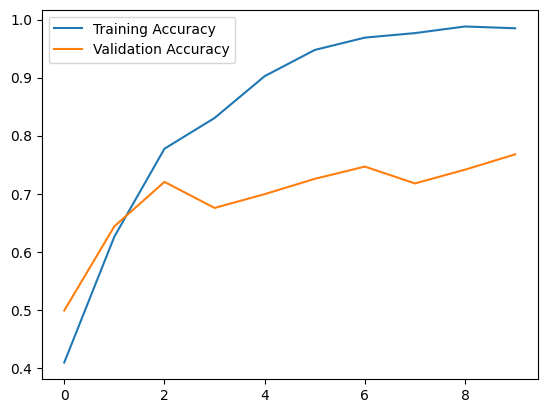

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 127008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      16,257,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,775,694 (186.06 MB)

 Trainable params: 16,258,564 (62.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 32,517,130 (124.04 MB)

In [26]:
test_loss, test_accuracy = model.evaluate(x_test,
y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


12/12 - 1s - 67ms/step - accuracy: 0.7627 - loss: 6.9711
Test Accuracy: 76.27%


# Save the model

In [28]:
# Save the model
model.save('wildlife_cnn_model.keras')
print("Model saved as wildlife_cnn_model.h5")
# Load the model
loaded_model = tf.keras.models.load_model('wildlife_cnn_model.keras')

Model saved as wildlife_cnn_model.h5


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


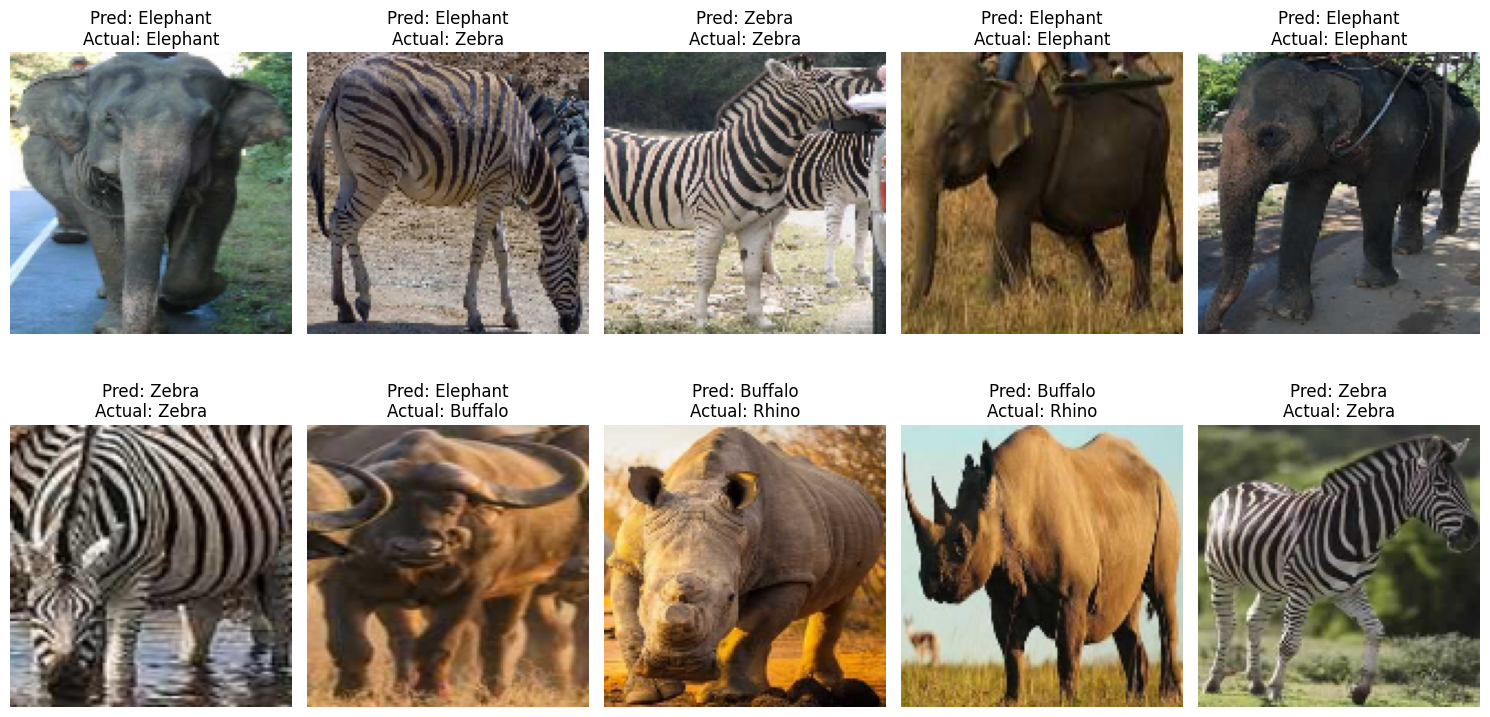

In [30]:
import random

random.seed(123)
indices = random.sample(range(len(x_test)), 10)
selected_images = x_test[indices]
actual_labels = y_test[indices]

# Normalize images if the model expects it
selected_images_normalized = selected_images / 516.0  # Adjust based on your model

# Make predictions
predictions = model.predict(selected_images_normalized)
predicted_labels = np.argmax(predictions, axis=1)

# Mapping labels back to class names
label_map = {0: "Buffalo", 1: "Elephant", 2: "Rhino", 3: "Zebra"}

# Display images with predicted and actual labels
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(selected_images[i])
    plt.axis('off')
    plt.title(f"Pred: {label_map.get(predicted_labels[i])}\nActual: {label_map.get(actual_labels[i])}")

plt.tight_layout()
plt.show()

# Observation
The model seems to correctly label all the sample test Elephant photos given to it

From the sample, the model mislabels Zebras once

The model seems to mislabel data as follows

|Actual data| Mislabelled identity|
|:----|:----|
|Zebra|Elephant|
|Buffalo|Elephant|
|Rhino|Buffalo|

This is based on 2 hidden layers

## Trying 4 layers

In [31]:
model_4_layer = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(4, 4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 classes (Buffalo, Elephant, Rhino, Zebra)
])

model_4_layer.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model_4_layer.fit(train_ds, epochs=10, validation_data = (x_valid, y_valid))
model_4_layer.summary()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3966 - loss: 399.9607 - val_accuracy: 0.5726 - val_loss: 5.0491
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7036 - loss: 2.6274 - val_accuracy: 0.6834 - val_loss: 1.7697
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8564 - loss: 0.6647 - val_accuracy: 0.7150 - val_loss: 1.4820
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9055 - loss: 0.3054 - val_accuracy: 0.7045 - val_loss: 1.5278
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9303 - loss: 0.1744 - val_accuracy: 0.7335 - val_loss: 1.4725
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9635 - loss: 0.0941 - val_accuracy: 0.7177 - val_loss: 1.5231
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9687 - loss: 0.0836 - val_accuracy: 0.7071 - val_loss: 1.6178
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9723 - loss: 0.0883 - val_accuracy: 0.7309 - val_loss: 1.6594


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30752)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,936,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,813,390 (45.06 MB)

 Trainable params: 3,937,796 (15.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,875,594 (30.04 MB)

In [32]:
test_4_loss, test_4_accuracy = model_4_layer.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_4_accuracy * 100:.2f}%")

12/12 - 1s - 44ms/step - accuracy: 0.8160 - loss: 1.0801
Test Accuracy: 81.60%


In [33]:
model_4_layer.save('wildlife_4_layer_model.keras')
print("Model saved as wildlife_4_layer_model.keras")
# Load the model
loaded_4_layer_model = tf.keras.models.load_model('wildlife_4_layer_model.keras')

Model saved as wildlife_4_layer_model.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


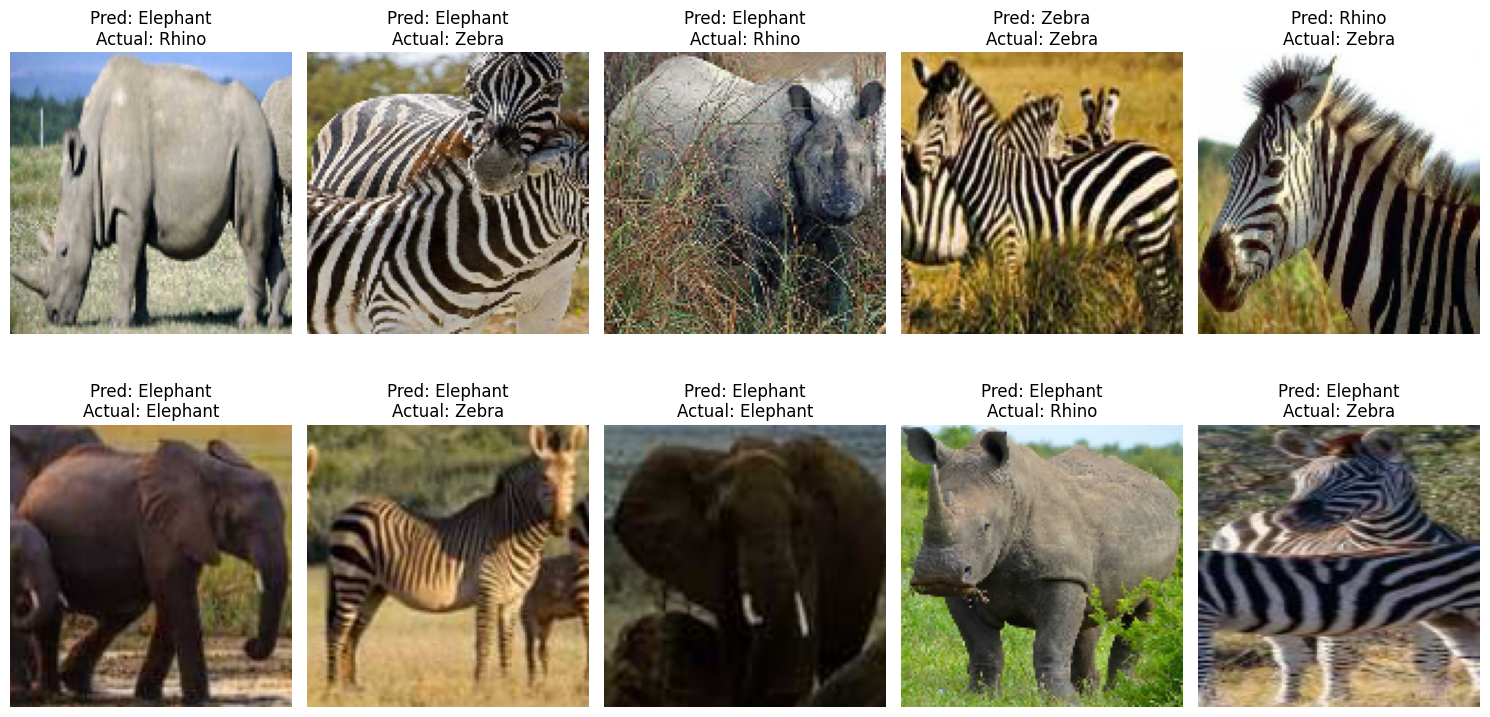

In [35]:
random.seed(111)
indices = random.sample(range(len(x_test)), 10)
selected_images = x_test[indices]
actual_labels = y_test[indices]

# Normalize images if the model expects it
selected_images_normalized = selected_images / 516.0  # Adjust based on your model

# Make predictions
predictions = loaded_4_layer_model.predict(selected_images_normalized)
predicted_labels = np.argmax(predictions, axis=1)

# Mapping labels back to class names
label_map = {0: "Buffalo", 1: "Elephant", 2: "Rhino", 3: "Zebra"}

# Display images with predicted and actual labels
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(selected_images[i])
    plt.axis('off')
    plt.title(f"Pred: {label_map.get(predicted_labels[i])}\nActual: {label_map.get(actual_labels[i])}")

plt.tight_layout()
plt.show()

In [36]:
model_6_layer = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(6, 6),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 classes (Buffalo, Elephant, Rhino, Zebra)
])

model_6_layer.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model_6_layer.fit(train_ds, epochs=10, validation_data = (x_valid, y_valid))

test_6_loss, test_6_accuracy = model_6_layer.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_6_accuracy * 100:.2f}%")

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.3933 - loss: 158.8198 - val_accuracy: 0.5435 - val_loss: 2.4320
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6746 - loss: 1.6101 - val_accuracy: 0.6280 - val_loss: 1.3545
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7857 - loss: 0.7535 - val_accuracy: 0.6834 - val_loss: 1.1850
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8550 - loss: 0.3671 - val_accuracy: 0.6174 - val_loss: 1.3159
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9149 - loss: 0.2701 - val_accuracy: 0.6807 - val_loss: 1.1458
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9567 - loss: 0.1657 - val_accuracy: 0.6649 - val_loss: 1.1806
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9774 - loss: 0.1106 - val_accuracy: 0.6887 - val_loss: 1.2160
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9613 - loss: 0.1317 - val_accuracy: 0.6728 - val_

# Observation

The increased layers improves the accuracy of the data prediction

accuracy:

|2 hidden layers|4 hidden layers|6 hidden layers|
|:----|:----|:----|
|76.27|81.60|77.07|

seems like 4 layers are the optimum number of hidden layers for this data